<a href="https://colab.research.google.com/github/amita-kapoor/COVID-2020/blob/master/Prediction_Covid_19_WorldWide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid 19 cases World Wide Analysis 
Data Source: https://github.com/CSSEGISandData/COVID-19

In [1]:
!pip install geopandas

     |████████████████████████████████| 931kB 1.4MB/s 
     |████████████████████████████████| 10.4MB 12.6MB/s 
     |████████████████████████████████| 14.7MB 329kB/s 


In [0]:
from datetime import timedelta, date, datetime
#import datetime as dt
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# Read data 
Data source: [CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)

In [0]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 1, 22)
end_dt = date(2020, 4, 2)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%m-%d-%Y"))


In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
df1 = pd.read_csv(url+dates[0]+'.csv')
for dt in tqdm(dates):
  #print(dt)
  df2 = pd.read_csv(url+dt+'.csv')
  if datetime.strptime(dt,"%m-%d-%Y")  > datetime.strptime("03-21-2020", "%m-%d-%Y"): 
    print(dt)
    df2.rename(columns={'Province_State': 'Province/State', 'Country_Region':'Country/Region','Last_Update': 'Last Update'}, inplace = True)
    df2.drop(['FIPS'], axis=1, inplace=True)
    df2.drop(['Admin2'], axis=1, inplace=True)
    df2.drop(['Active'], axis=1, inplace=True)
    df2.drop(['Combined_Key'], axis=1, inplace=True)
  df1 = pd.merge(df1, df2, how='outer' )

 85%|████████▍ | 61/72 [00:22<00:04,  2.47it/s]

03-22-2020


 86%|████████▌ | 62/72 [00:23<00:04,  2.34it/s]

03-23-2020


 88%|████████▊ | 63/72 [00:24<00:05,  1.59it/s]

03-24-2020


 89%|████████▉ | 64/72 [00:24<00:04,  1.72it/s]

03-25-2020


 90%|█████████ | 65/72 [00:25<00:03,  1.79it/s]

03-26-2020


 92%|█████████▏| 66/72 [00:25<00:03,  1.81it/s]

03-27-2020


 93%|█████████▎| 67/72 [00:26<00:02,  1.89it/s]

03-28-2020


 94%|█████████▍| 68/72 [00:26<00:02,  1.93it/s]

03-29-2020


 96%|█████████▌| 69/72 [00:27<00:01,  1.85it/s]

03-30-2020


 97%|█████████▋| 70/72 [00:28<00:01,  1.40it/s]

03-31-2020


 99%|█████████▊| 71/72 [00:29<00:00,  1.52it/s]

04-01-2020


100%|██████████| 72/72 [00:29<00:00,  2.46it/s]

04-02-2020


In [0]:
df1.drop(['Province/State'], axis=1, inplace=True)
df1['Last Update']= pd.to_datetime(df1['Last Update']) 
df1['Last Update'] = df1['Last Update'].dt.date
df1.fillna(0, inplace = True)

In [0]:
dict_country = {'Cote d\'Ivoire': 'Côte d\'Ivoire', 'Martinique':'France', 'Hong Kong':'China',
                'North Korea':'Korea, Democratic People\'s Republic of','Republic of Korea':'South Korea',
                'Korea, South': 'South Korea','US':'United States of America','UK':'United Kingdom',
                'Mainland China':'China','Iran (Islamic Republic of)':'Iran', 'Czech Republic': 'Czechia',
                'Hong Kong SAR': 'Hong Kong','Bosnia and Herzegovina': 'Bosnia and Herz.','Republic of Ireland':'Ireland',
                ' Azerbaijan':'Azerbaijan', 'Andorra':'Italy','Aruba':'Netherlands','Cayman Islands':'United Kingdom',
                'Central African Republic':'Central African Rep.','Channel Islands':'United Kingdom',
                'Congo (Brazzaville)':'Congo','Congo (Kinshasa)':'Congo','Viet Nam':'Vietnam',
                'Equatorial Guinea': 'Eq. Guinea', 'Eswatini':'eSwatini' ,'occupied Palestinian territory':'Palestine',
                'Vatican City':'Italy','The Bahamas':'Bahamas','Taiwan*':'Taiwan','Taipei and environs':'Taiwan','Holy See':'Italy',
                'Saint Martin':'St. Martin','Singapore':'China','Russian Federation':'Russia',
                'Republic of the Congo':'Congo','Republic of Moldova':'Moldova','North Macedonia':'Macedonia',
                'North Ireland':'United Kingdom','Monaco':'Others','Seychelles':'Others','Saint Vincent and the Grenadines':'Others',
                'Antigua and Barbuda':'Others','Bahrain':'Others','Cruise Ship':'Others', 'Curacao':'Others','Dominican Republic':'Dominican Rep.',
                'Faroe Islands': 'Others', 'French Guiana':'Others','Gibraltar':'Others','Guadeloupe':'Others','Guam':'Others','Ivory Coast':'Côte d\'Ivoire'}
for key, value in dict_country.items():
  df1['Country/Region'].replace([key], value,inplace=True)

In [7]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Lat,Long_
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43173 entries, 0 to 43172
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country/Region  43173 non-null  object 
 1   Last Update     43173 non-null  object 
 2   Confirmed       43173 non-null  float64
 3   Deaths          43173 non-null  float64
 4   Recovered       43173 non-null  float64
 5   Latitude        43173 non-null  float64
 6   Longitude       43173 non-null  float64
 7   Lat             43173 non-null  float64
 8   Long_           43173 non-null  float64
dtypes: float64(7), object(2)
memory usage: 3.3+ MB


In [9]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Lat,Long_
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df1 = pd.pivot_table(df1, index=['Country/Region','Last Update'], aggfunc={'Confirmed':np.sum, 'Deaths':np.sum,\
                                                                           'Recovered':np.sum,'Latitude':np.max,\
                                                                           'Longitude':np.max})

In [11]:
df1.head(10)


Confirmed  Deaths  Latitude  Longitude  Recovered
Country/Region Last Update                                                   
Afghanistan    2020-02-24         1.0     0.0   33.0000      65.00        0.0
               2020-03-08         4.0     0.0   33.0000      65.00        0.0
               2020-03-10         5.0     0.0   33.0000      65.00        0.0
               2020-03-11        14.0     0.0   33.0000      65.00        0.0
               2020-03-14        11.0     0.0   33.9391      67.71        0.0
               2020-03-15        16.0     0.0   33.9391      67.71        0.0
               2020-03-16        21.0     0.0   33.9391      67.71        1.0
               2020-03-17        22.0     0.0   33.9391      67.71        1.0
               2020-03-20        24.0     0.0   33.9391      67.71        1.0
               2020-03-22        40.0     1.0    0.0000       0.00        1.0

In [0]:
def plot_percent(df_country, Country):
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
  #ax = df_country.plot('Last Update', 'deceased_percent')
  ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
def plot_total(df_country, Country, bar=False):
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  df_country['Active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
  
  if bar:
    ax = df_country.plot.bar(x='Last Update', y=['Active', 'Recovered', 'Deaths'],stacked=True)
  else:
    ax = df_country.plot('Last Update', ['Active', 'Recovered', 'Deaths'])
  ax.set_ylabel("Number", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Active, Recovered and Deaths in  "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
from scipy.optimize import curve_fit
def prediction_country(Country, df1, plot= False, plot_p = False, plot_t = False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  # Adding percentage of Deceased and ICU 

  df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
  df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100
  df_country['active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
  
  
            

  if plot_p: plot_percent(df_country, Country)
  if plot_t: plot_total(df_country, Country)
  xdata=np.array(range(df_country.shape[0]))
  ydata=df_country['Confirmed'].values

  def func(x,a,b):
    return a*2**(x/b)
    
  try:
    popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    perr = np.sqrt(np.diag(pcov))
    resid = np.linalg.norm(ydata-func(xdata, *popt))
  except:
    popt = np.array([0,0])
  #print("For {} the coefficients of function is \n {} * 2 ** (t/{}) \n The covariance is:\n {} \n and the error is {}".format(Country,popt[0], popt[1], pcov, resid))

  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  return [Country, df_country['Last Update'][0],df_country['Confirmed'].iloc[-1], df_country['active'].iloc[-1],\
          df_country['deceased_percent'].iloc[-1], df_country['recovered_percent'].iloc[-1],popt[0],popt[1], \
          df_country['Latitude'].iloc[-1],df_country['Longitude'].iloc[-1]] 



In [0]:
from scipy.optimize import curve_fit
def prediction_country2(Country, df1, plot=True,predict=False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  #print(len(x))

 
  def func(x,a,b):
    return a*2**(x/b)
  
  list_coeff = [Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff.append(popt[1])
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  if predict:
    x_new = [range(60)]
    predict_result = np.asarray([func(i, popt[0],popt[1]) for i in x_new])
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = predict_result
    #perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(yfit,'-',label=f'Exponential fit')
    ax1.legend(fontsize=15)
    plt.show()

  return list_coeff


In [0]:
from scipy.optimize import curve_fit
def prediction_country3(Country, df1, plot=True,predict=False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
  df_country['weekly_increase'] = (df_country['Confirmed']/ df_country['Confirmed'].shift(7) - 1) * 100
  df_country['daily_increase'] = (df_country['Confirmed'] / df_country['Confirmed'].shift(1) - 1) * 100

  
  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  #print(len(x))

 
  def func(x,a,b):
    return a*2**(x/b)
  
  list_coeff = np.zeros(df_country.shape[0]) #[Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff[i] = popt[1]
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  if predict:
    x_new = [range(60)]
    predict_result = np.asarray([func(i, popt[0],popt[1]) for i in x_new])
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = predict_result
    #perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(yfit,'-',label=f'Exponential fit')
    ax1.legend(fontsize=15)
    plt.show()
  list_coeff = np.asarray(list_coeff)
  df_country["Doubling_time"] = list_coeff
  df_country["Country"] = [Country  for _ in range(df_country.shape[0])]
  return df_country


In [0]:
Countries = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy"]
#Countries = set(df1.reset_index()['Country/Region'].tolist())

100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


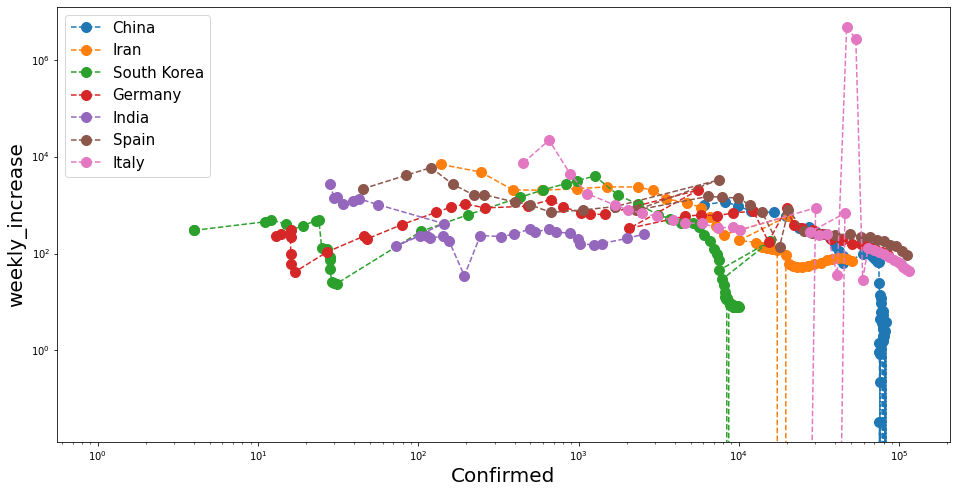

In [18]:
dff = pd.DataFrame(columns=['Country', "Doubling_time"])
Column = "weekly_increase"
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel(Column,fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)

for Country in tqdm(Countries):
  dff2 = prediction_country3(Country, df1,plot=False)
  dff2.plot("Confirmed", "weekly_increase", ls='--', marker='o', ax=ax1, ms=10,label=Country)

  dff = pd.merge(dff,dff2, how='outer')
ax1.legend(fontsize=15)

In [19]:
dff.head()

,Last Update,Confirmed,Deaths,Latitude,Longitude,Recovered,weekly_increase,daily_increase,Doubling_time,Country
0,2020-01-22,547.0,17.0,0.0,0.0,28.0,NaN,NaN,0.0,China
1,2020-01-23,642.0,18.0,0.0,0.0,30.0,NaN,17.367459,0.0,China
2,2020-01-24,921.0,26.0,0.0,0.0,36.0,NaN,43.457944,0.0,China
3,2020-01-25,1407.0,42.0,0.0,0.0,39.0,NaN,52.768730,0.0,China
4,2020-01-26,2074.0,56.0,0.0,0.0,49.0,NaN,47.405828,0.0,China


In [20]:
Countries = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy", "United States of America", "United Kingdom"]
List = []
for Country in tqdm(Countries):
  coeff = prediction_country2(Country, df1,plot=False)
  List.append(coeff)

100%|██████████| 9/9 [00:00<00:00, 15.04it/s]


In [0]:
df_combines = pd.DataFrame(List).T

In [0]:
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

In [23]:
df_combines

,China,Iran,South Korea,Germany,India,Spain,Italy,United States of America,United Kingdom
1,2.37534,1.46859,2.55368,4.24843,1.85762,1.48148,1.87864,4.96757,3.10638
2,2.62386,1.52231,2.49846,4.86703,2.36829,1.67929,2.08684,2.58907,2.74167
3,2.59604,1.47737,2.58495,5.62366,2.78295,1.86263,2.04362,4.94625,2.90559
4,2.74836,1.51846,2.96266,6.47299,3.19242,2.18377,2.24987,8.94521,2.9572
5,2.91505,1.54193,3.22009,7.1941,3.32391,2.12714,2.4616,12.8004,2.44257
6,3.13633,1.81276,3.37612,6.31375,1.84979,2.25684,2.64228,23.3029,2.26426
7,3.42334,2.12189,3.73351,4.38156,3.12145,2.31254,2.77371,33.1132,2.14719
8,3.71474,2.25482,4.1678,3.99031,3.52501,2.06932,2.9302,0.351909,2.25832
9,4.05222,2.44243,4.5711,2.94634,3.88353,1.81643,2.99397,4.59031,2.32871
10,4.39756,2.73979,5.01976,2.03401,4.28641,0.556929,3.03018,1.78977,2.55562


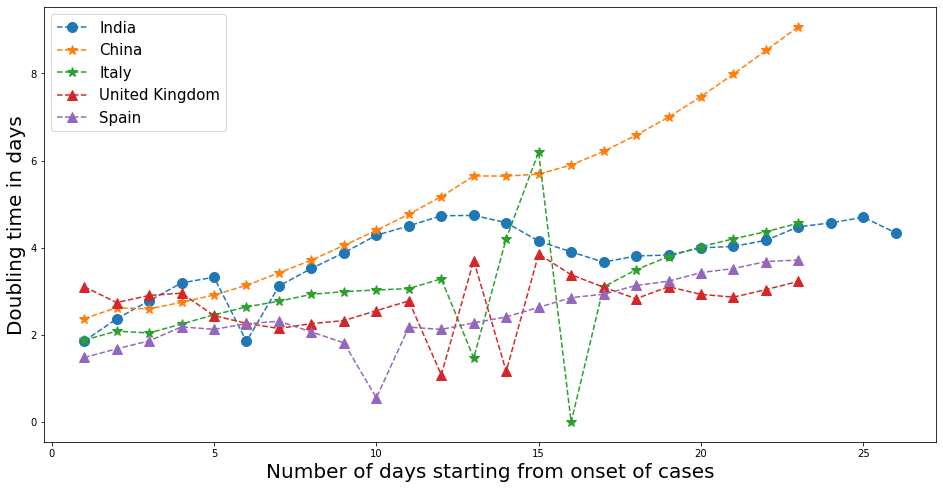

In [24]:
num = 23
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'].iloc[:num],'--*',ms=10,label='China')
#ax1.plot(df_combines['Germany'].iloc[:num],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'].iloc[:num],'--*',ms=10,label='Italy')
#ax1.plot(df_combines['Iran'].iloc[:num],'--^',ms=10,label='Iran')
ax1.plot(df_combines['United Kingdom'].iloc[:num],'--^',ms=10,label='United Kingdom')
ax1.plot(df_combines['Spain'].iloc[:num],'--^',ms=10,label='Spain')
#ax1.plot(df_combines['United States of America'].iloc[:num],'--^',ms=10,label='United States of America')
ax1.legend(fontsize=15)
#plt.show()

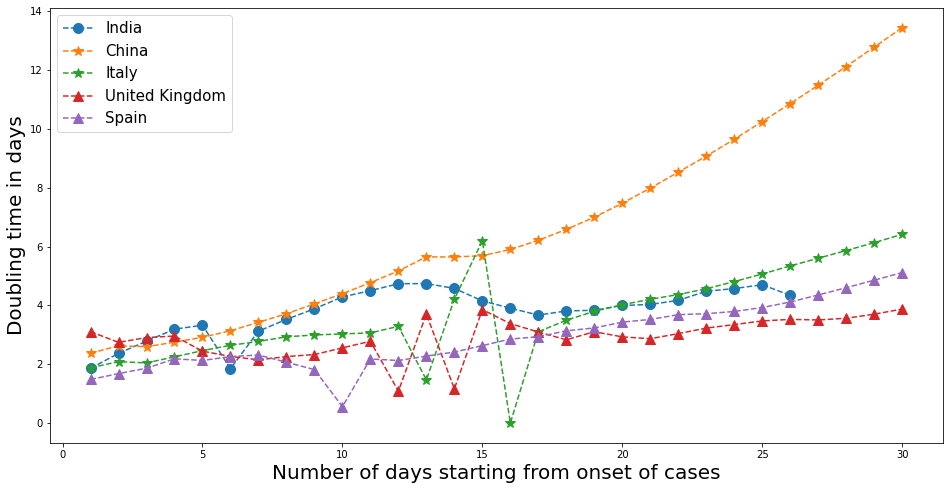

In [25]:
num = 30
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'].iloc[:num],'--*',ms=10,label='China')
#ax1.plot(df_combines['Germany'].iloc[:num],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'].iloc[:num],'--*',ms=10,label='Italy')
#ax1.plot(df_combines['Iran'].iloc[:num],'--^',ms=10,label='Iran')
ax1.plot(df_combines['United Kingdom'].iloc[:num],'--^',ms=10,label='United Kingdom')
ax1.plot(df_combines['Spain'].iloc[:num],'--^',ms=10,label='Spain')
ax1.legend(fontsize=15)
#plt.show()

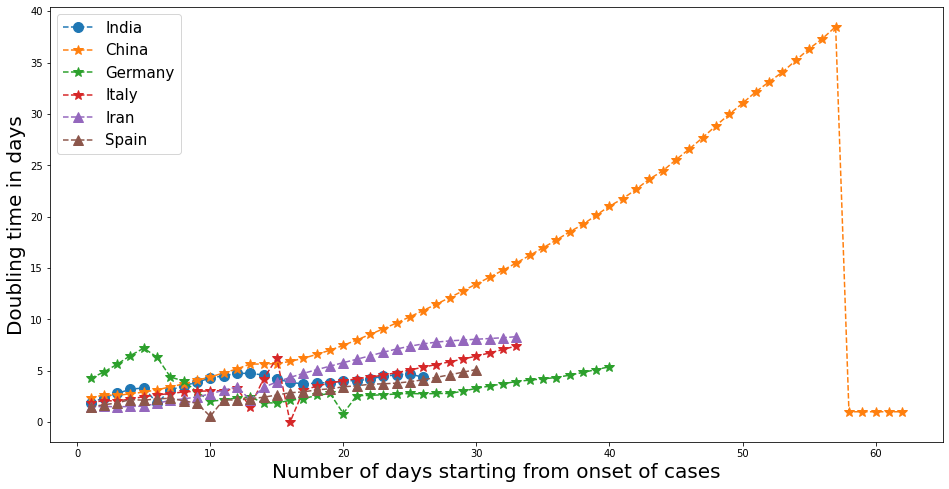

In [26]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'],'--*',ms=10,label='China')
ax1.plot(df_combines['Germany'],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'],'--*',ms=10,label='Italy')
ax1.plot(df_combines['Iran'],'--^',ms=10,label='Iran')
ax1.plot(df_combines['Spain'],'--^',ms=10,label='Spain')
ax1.legend(fontsize=15)
#plt.show()

In [27]:
List = []
for Country in tqdm(Countries):
  List.append(prediction_country(Country, df1))

100%|██████████| 9/9 [00:00<00:00, 108.10it/s]


In [28]:
df_summary = pd.DataFrame(List, columns = ["Country", "First_Case", "Total_Confirmed_Today", "Active","Deceased_Percent",\
                                          "Recovered_Percent","First_Coeff", "Doubling_time_in_days","Latitude", "Longitude"])
df_summary.head()

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,First_Coeff,Doubling_time_in_days,Latitude,Longitude
0,China,2020-01-22,78070.0,3169.0,4.185987,91.754835,1.652898e-14,1.000000,0.0,0.0
1,Iran,2020-02-19,50468.0,30597.0,6.261393,33.112071,1.670685e+03,8.436169,0.0,0.0
2,South Korea,2020-01-22,9976.0,3979.0,1.694066,58.420209,1.703069e-14,1.000000,0.0,0.0
3,Germany,2020-01-28,84794.0,61247.0,1.305517,26.464137,2.228341e+02,5.629794,0.0,0.0
4,India,2020-01-30,2543.0,2280.0,2.831302,7.510814,5.154903e+00,3.964967,0.0,0.0


In [29]:
df_summary

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,First_Coeff,Doubling_time_in_days,Latitude,Longitude
0,China,2020-01-22,78070.0,3169.0,4.185987,91.754835,1.652898e-14,1.000000,0.0,0.0
1,Iran,2020-02-19,50468.0,30597.0,6.261393,33.112071,1.670685e+03,8.436169,0.0,0.0
2,South Korea,2020-01-22,9976.0,3979.0,1.694066,58.420209,1.703069e-14,1.000000,0.0,0.0
3,Germany,2020-01-28,84794.0,61247.0,1.305517,26.464137,2.228341e+02,5.629794,0.0,0.0
4,India,2020-01-30,2543.0,2280.0,2.831302,7.510814,5.154903e+00,3.964967,0.0,0.0
5,Spain,2020-02-01,112065.0,74974.0,9.233927,23.863829,8.141476e+02,5.383832,0.0,0.0
6,Italy,2020-01-31,115677.0,83459.0,12.042152,15.809539,3.089094e+03,7.743398,0.0,0.0
7,United States of America,2020-01-22,243453.0,228526.0,2.434145,3.697223,1.607082e+01,4.007758,0.0,0.0
8,United Kingdom,2020-01-31,34173.0,31055.0,8.562315,0.561847,4.742038e+01,4.295387,0.0,0.0


India 5.1549028938967885 3.964967019661384


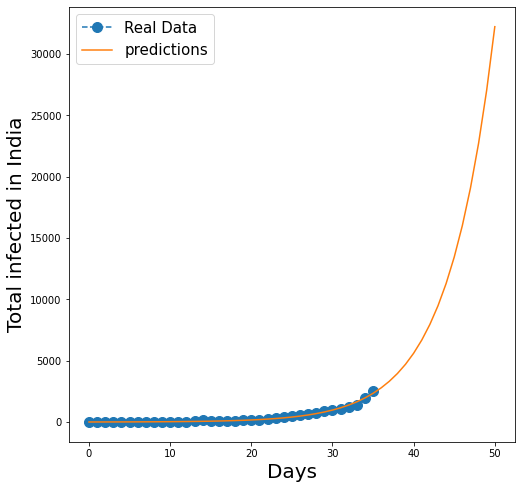

In [30]:
loc = 4
Country = df_summary.loc[loc].Country
df_country = df1.loc[Country]
df_country.reset_index(inplace=True)
orig = df_country['Confirmed'].tolist()
coeff1, coeff2 = df_summary.loc[loc].First_Coeff, df_summary.loc[loc].Doubling_time_in_days
print(Country, coeff1, coeff2)
predictions = []
for i in range(51):
  yfit = coeff1*2**(i/coeff2)
  predictions.append(yfit)

fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax1.set_ylabel('Total infected in '+Country,fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
ax1.plot(orig,'--o',ms=10,label='Real Data')
#ax1.plot(yfit,'-',label=f'Exponential fit')
plt.plot(predictions, label='predictions')
ax1.legend(fontsize=15)

In [31]:
predictions

[5.1549028938967885,
 6.139640396624768,
 7.312491617348682,
 8.709391788351477,
 10.373140824263483,
 12.354714677541073,
 14.714827201267326,
 17.52579037351362,
 20.873729879062996,
 24.86122393216405,
 29.610446191754193,
 35.26690906558481,
 42.00392209512144,
 50.02790202260029,
 59.584697236489276,
 70.96712037135231,
 84.5239198550092,
 100.6704652840894,
 119.9014740194215,
 142.80616893405914,
 170.08633173533553,
 202.5778050004322,
 241.2761017307983,
 287.36690708188064,
 342.26240681699966,
 407.6445555604183,
 485.51661055460505,
 578.2645098751829,
 688.7299756834524,
 820.2975823422333,
 976.998457093117,
 1163.6337906017345,
 1385.9219416363,
 1650.6736430502444,
 1966.0006772414604,
 2341.564414738905,
 2788.8718309419723,
 3321.6280707310334,
 3956.1563632495004,
 4711.898152713694,
 5612.008768862336,
 6684.066887916337,
 7960.919521370674,
 9481.688422405561,
 11292.968745412045,
 13450.256684610384,
 16019.649833477471,
 19079.87236264918,
 22724.687066144143,
 2

In [32]:
world_path = gpd.datasets.get_path('naturalearth_lowres')
World = gpd.read_file(world_path)
World.columns = ['pop_est', 'continent', 'Country', 'iso_a3', 'gdp_md_est', 'geometry']
print(len(World['Country']))
World = pd.merge(World, df_summary, on='Country',how='left')
World["Total_per_pop"] = World['Total_Confirmed_Today']/World['pop_est']*100
World.fillna(0,inplace=True)

177


Text(0.5, 1.0, 'Total number of Covid confirmed per population as on 04-02-2020')

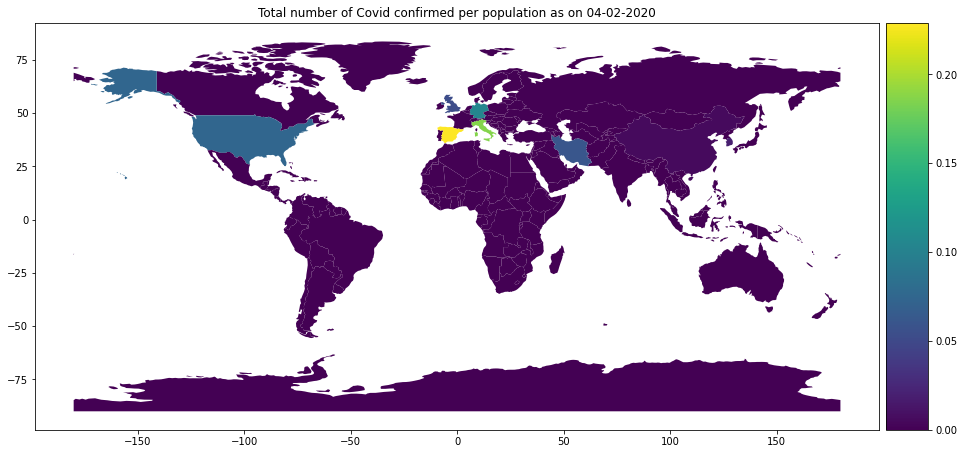

In [33]:
title = "Total_per_pop"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Total number of Covid confirmed per population as on "+dates[-1])

Text(0.5, 1.0, 'Total number of Covid confirmed as on 04-02-2020')

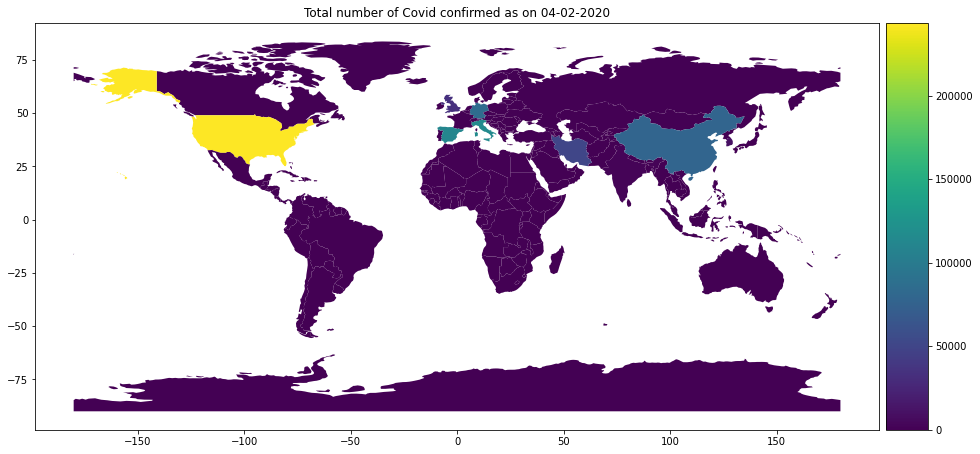

In [34]:
title = "Total_Confirmed_Today"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Total number of Covid confirmed as on "+dates[-1])

Text(0.5, 1.0, 'Deceased Percentage as on 04-02-2020')

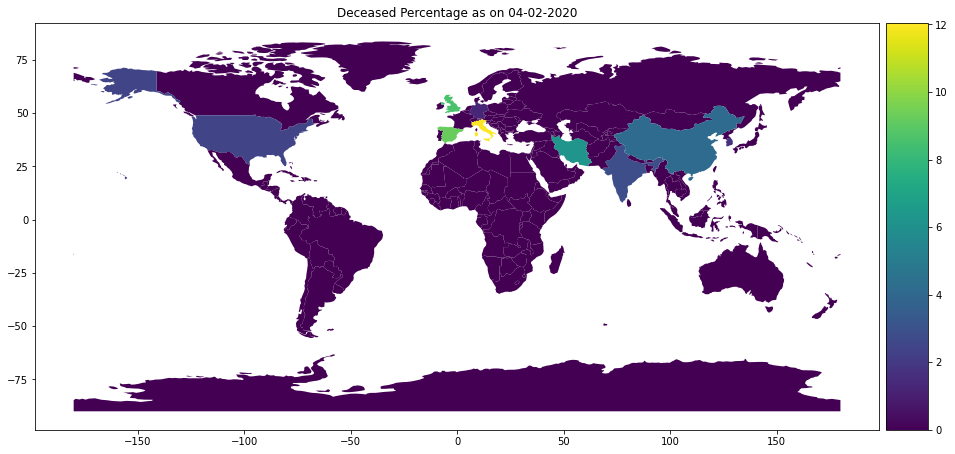

In [35]:
title = "Deceased_Percent"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Deceased Percentage as on "+dates[-1])

Text(0.5, 1.0, 'Recovered Percentage as on 04-02-2020')

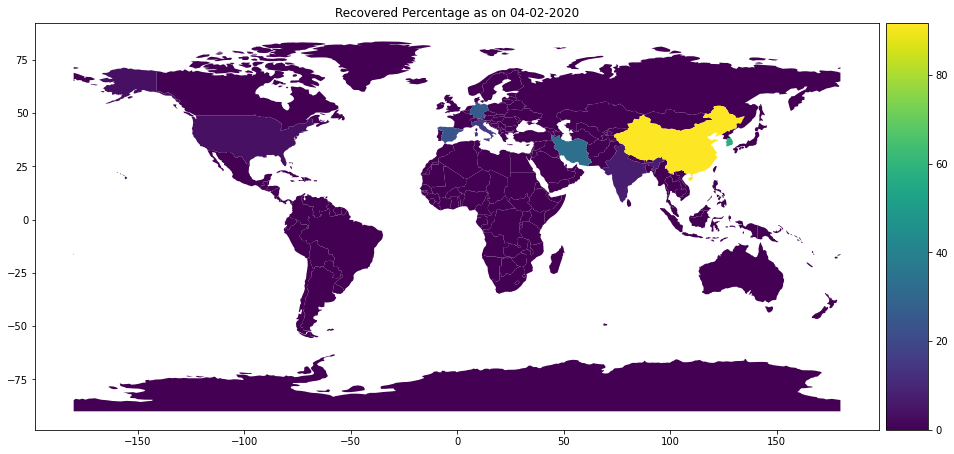

In [36]:
title = "Recovered_Percent"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Recovered Percentage as on "+dates[-1])

In [0]:
Country = "India"
df_china = df1.loc[Country]
df_china.reset_index(inplace=True)
df_china.drop(df_china.tail(1).index,inplace=True)
df_china['active'] = (df_china['Confirmed']- df_china['Deaths']-df_china['Recovered'])
df_china['c-d'] = (df_china['Confirmed']- df_china['Deaths'])

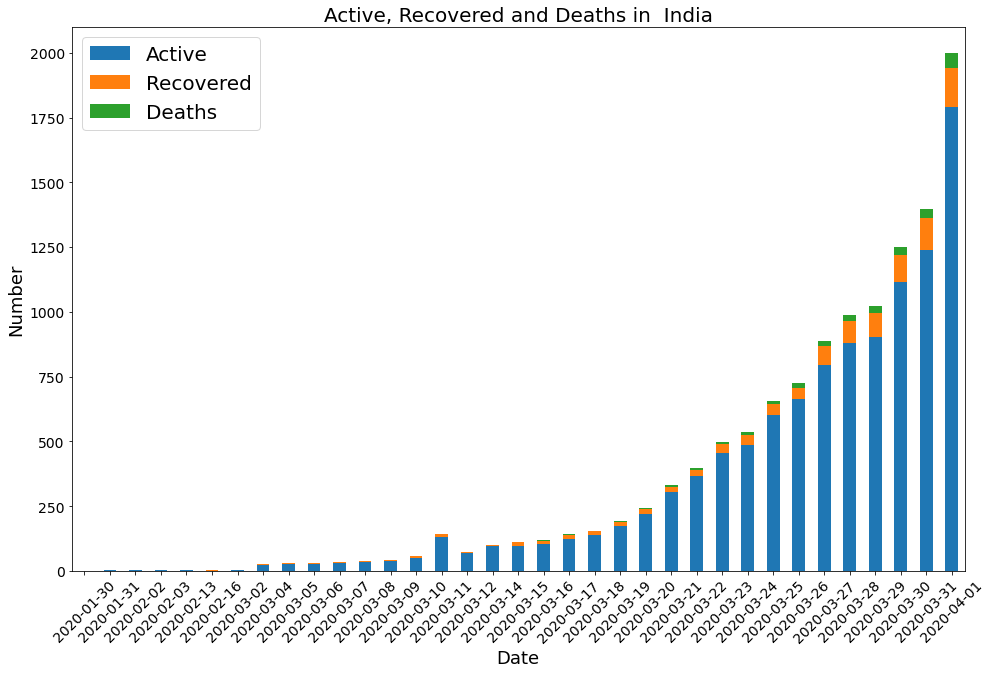

In [47]:
plot_total(df_china,Country,bar=True)

In [0]:
Country = "China"
df_china = df1.loc[Country]
df_china.reset_index(inplace=True)
df_china.drop(df_china.tail(1).index,inplace=True)
df_china['active'] = (df_china['Confirmed']- df_china['Deaths']-df_china['Recovered'])
df_china['c-d'] = (df_china['Confirmed']- df_china['Deaths'])
#df_china

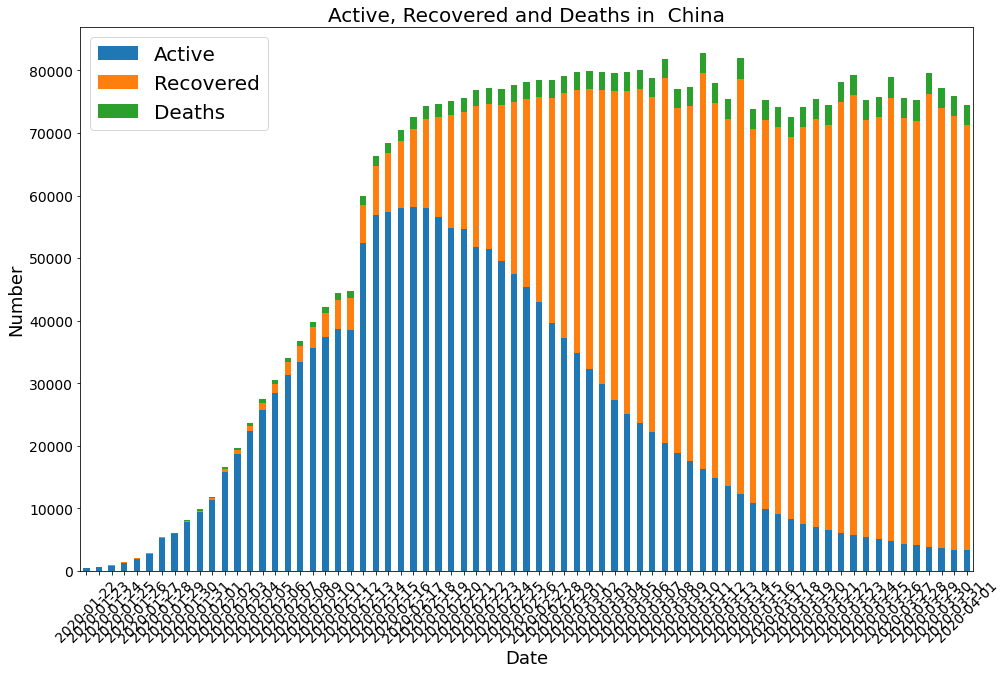

In [49]:
plot_total(df_china,Country,bar=True)

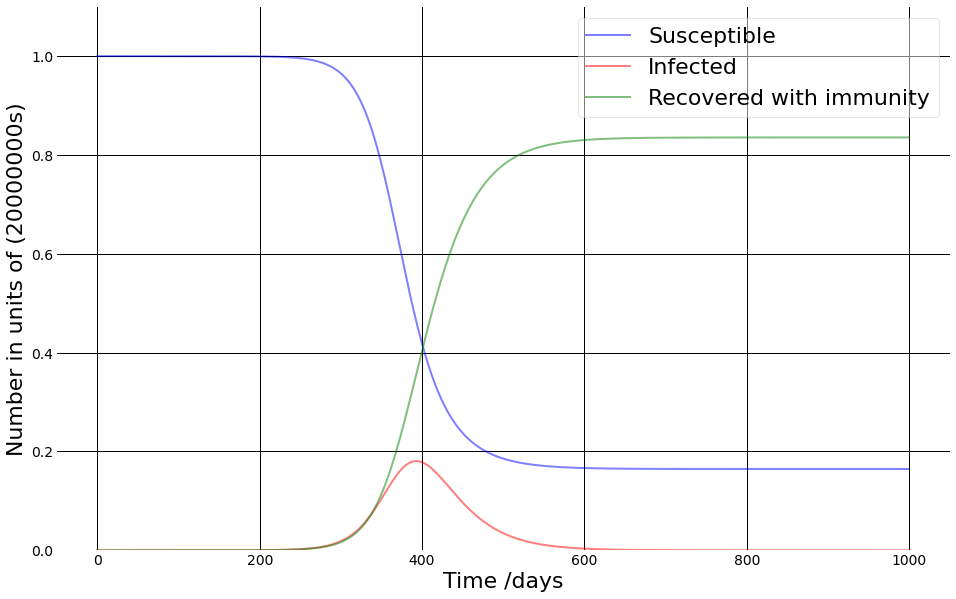

In [41]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 20000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.08, 1/27    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 1000, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

 # adapted code from:  https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

 # Reference: https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-contact-number

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text major ticklabel objects>)

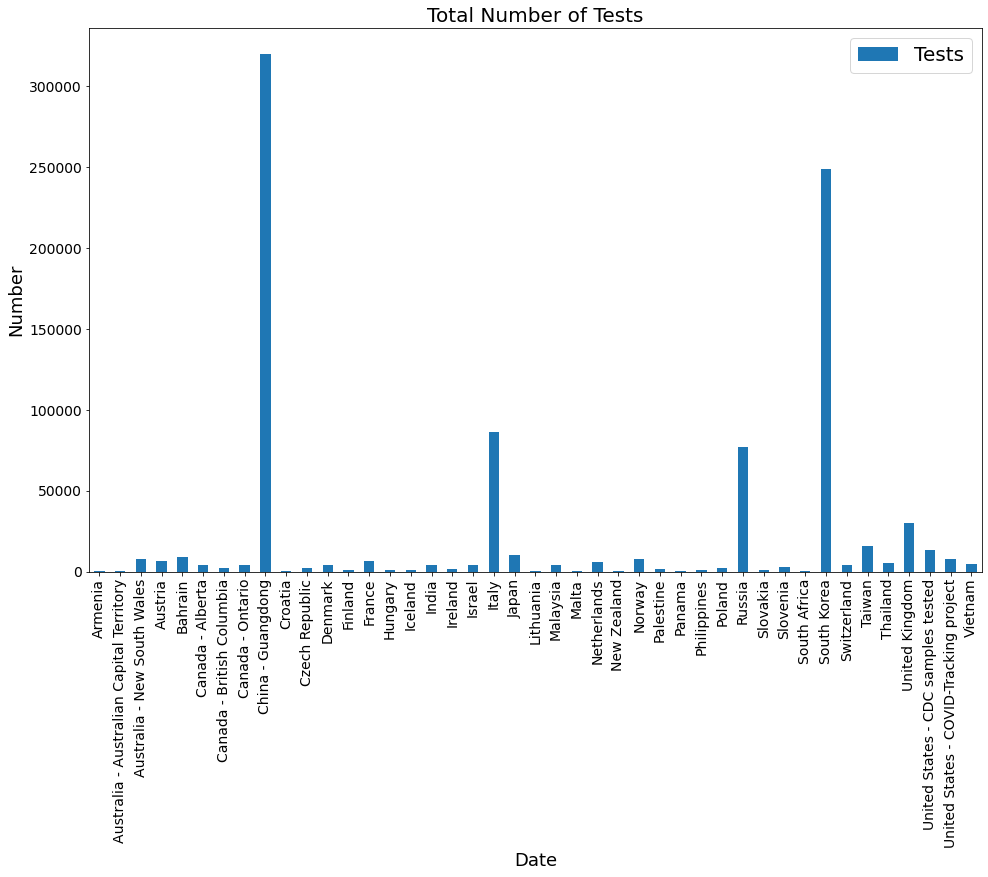

In [42]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests/COVID-19%20Tests.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Total Number of Tests", fontsize=20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

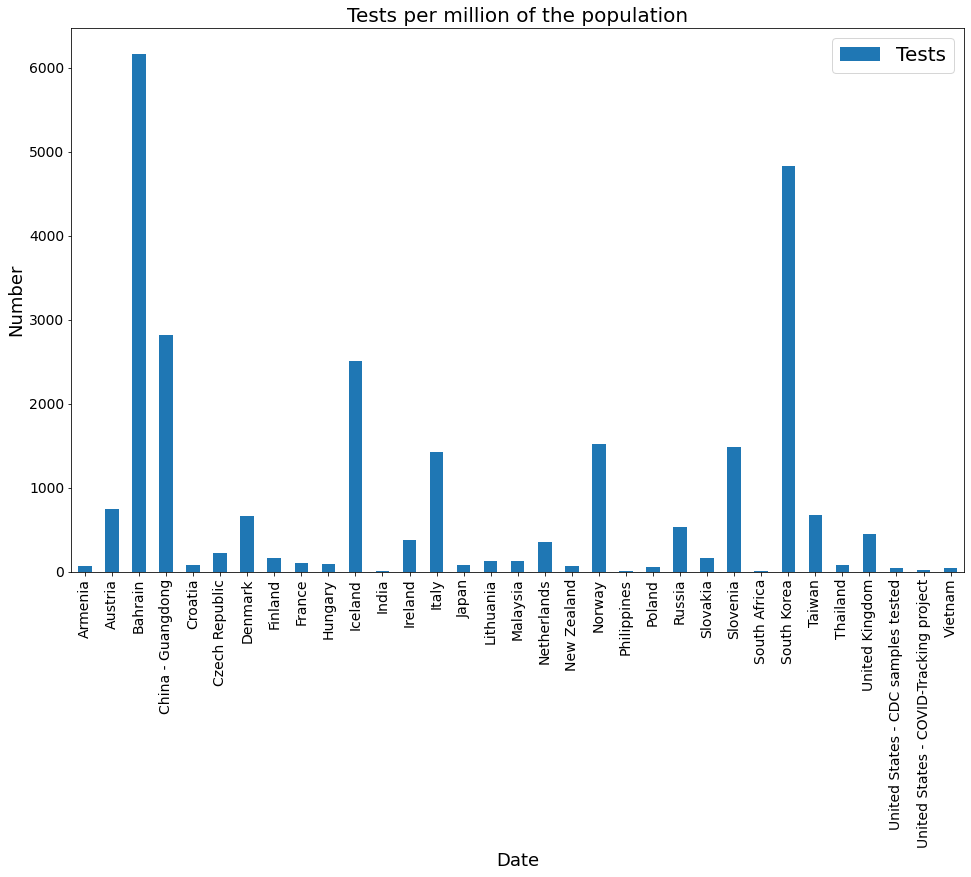

In [43]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests%20per%20million%20people/COVID-19%20Tests%20per%20million%20people.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

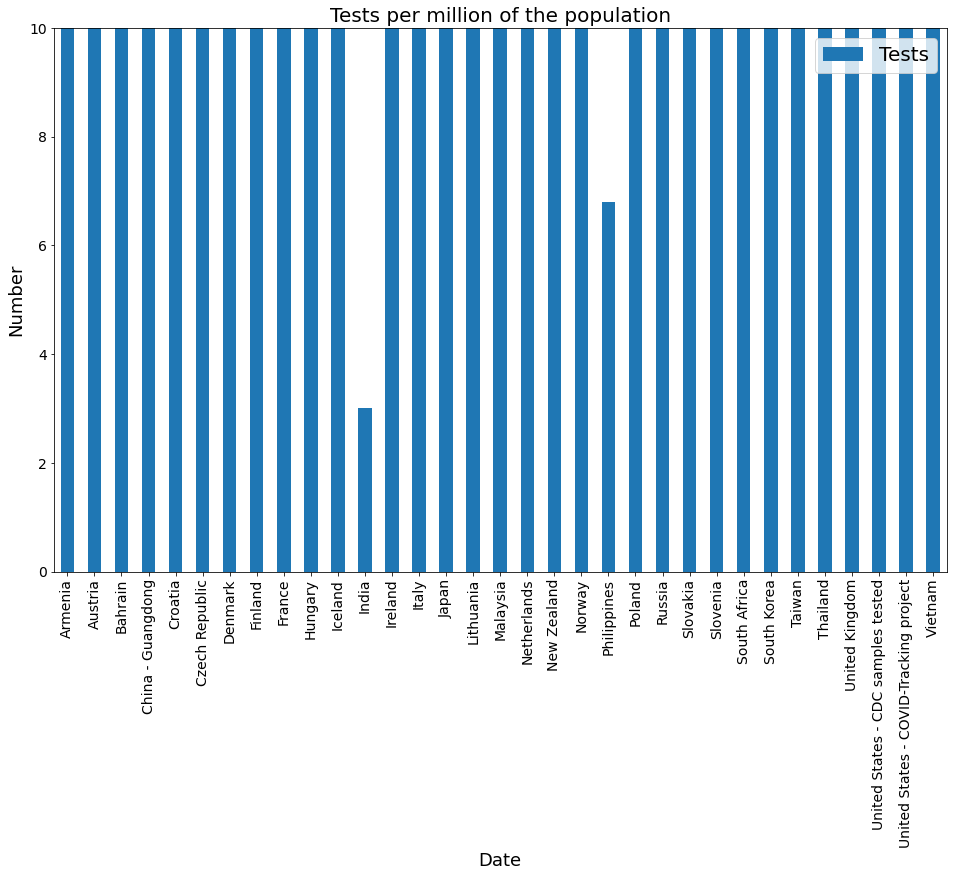

In [44]:
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_ylim(0,10)
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)